<a href="https://colab.research.google.com/github/dbstj1231/2023_AI_Academy_ASR/blob/main/7_WFST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nemo+K2 ASR Demo
---
WFST의 장점
- 지정된 unit들의 sequence를 가장 최적화해서 모델링할 수 있음  
⁻ (입력, 출력이 정해져 있는 경우에 대해 가장 좋은 모델링 방법)
- WFST의 효과  
⁻ 빠른 처리 속도 (shortest path가 지정되어 있으므로)  
---
  
 높은 성능을 보이는 음향 모델인 end-to-end 모델에 대하여, WFST로 표현된 word set과 언어 모델을 결합해 성능을 높임


materials

logits, indexed words, indexed tokens and lexicon from Nemo
Arpa format from n-gram models

## k2-fsa(k2)
-  OpenFST를 개량한 python 기반의 WFST 패키지
- End-to-end 모델과 WFST를 결합할 목적으로 제작됨
- FSA, FST를 tensor 형태로 구현하여 GPU에서 WFST 연산을 가능하게 함
- https://github.com/k2-fsa/k2

## K2 설치 및 기본 환경 세팅

### Prerequisities (pip 기준)
- Python >= 3.6
- CUDA >= 10.1
- PyTorch == 1.7.1 (conda 설치의 경우 >=1.7.1)

### PyPI (PIP)를 이용한 설치 방법 (권장, but colab에선 비권장)
- pip install k2 (Prerequisities 자동으로 설치됨)

### Colab에서 돌아가는 pip 설치 방법
- ! pip install torch==1.7.1
- ! pip install k2==1.17.dev20220710+cuda10.2.torch1.7.1 -f https://k2-fsa.org/nightly/

### Source code (github)을 이용한 설치 방법
- git clone https://github.com/k2-fsa/k2.git
- cd k2
- python3 setup.py install

In [1]:
!pip install torch==1.13.1 torchaudio==0.13.1
!pip install k2==1.24.3.dev20230629+cpu.torch1.13.1 -f https://k2-fsa.org/nightly/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 974.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [2]:
import k2, torch

In [3]:
import k2.version
k2.version.version.main()


k2 version: 1.24.3
Build type: Release
Git SHA1: 42e92fdd4097adcfe9937b4d2df7736d227b8e85
Git date: Wed Jun 28 01:50:36 2023
Cuda used to build k2: 
cuDNN used to build k2: 
Python version used to build k2: 3.10
OS used to build k2: Ubuntu 20.04.6 LTS
CMake version: 3.26.4
GCC version: 9.4.0
CMAKE_CUDA_FLAGS: 
CMAKE_CXX_FLAGS:  -D_GLIBCXX_USE_CXX11_ABI=0 -Wno-unused-variable  -Wno-strict-overflow 
PyTorch version used to build k2: 1.13.1+cpu
PyTorch is using Cuda: 
NVTX enabled: False
With CUDA: False
Disable debug: True
Sync kernels : False
Disable checks: False
Max cpu memory allocate: 214748364800 bytes (or 200.0 GB)
k2 abort: False
__file__: /usr/local/lib/python3.10/dist-packages/k2/version/version.py
_k2.__file__: /usr/local/lib/python3.10/dist-packages/_k2.cpython-310-x86_64-linux-gnu.so
    


## K2를 이용한 WFST 구현

### Weighted Finite-state Acceptor(WFSA)
- StartState \t EndState \t Symbol(index) \t Weight
- Symbol은 기본적으로 index로 표현/계산됨
- 시각화할 일이 있을 때만 symbol을 표현
- Symbol table 정의가 필요함
- 일반적으로 k2.Fsa.from_str()를 사용하여 생성함
- draw() or to_dot() methods를 이용하여 시각화

## WFSA creation

In [5]:
s = '''
0 1 1 1
0 1 3 5
0 2 1 3
0 2 2 4
0 2 3 7
0 2 4 8
0 2 5 9
1 3 6 9
1 3 5 8
2 3 6 12
3 4 -1 0
4
'''
a_fsa = k2.Fsa.from_str(s)

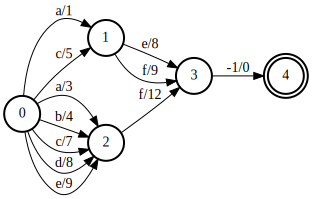

In [7]:
sym_str = '''
  <eps> 0
 a 1
 b 2
 c 3
 d 4
 e 5
 f 6
'''
a_fsa.symbols = k2.SymbolTable.from_str(sym_str)
a_fsa.labels_sym = k2.SymbolTable.from_str(sym_str)

a_fsa = k2.arc_sort(a_fsa)
a_fsa.draw('a_fsa.svg')

###  Weighted Finite-state Transducer(WFST)
- WFST: StartState \t EndState \t InputSymbol \t OutputSymbol\t Weight
- 시각화된 표현은 arc당 InputSymbol:OutputSymbol/weight
- CTC, lexicon, language model의 최적화된 표현을 위해
- k2.Fsa.from_str의 acceptor=False option을 이용하여 생성

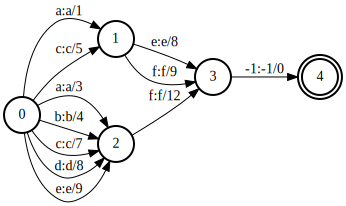

In [14]:
s = '''
0 1 1 1 1
0 1 3 3 5
0 2 1 1 3
0 2 2 2 4
0 2 3 3 7
0 2 4 4 8
0 2 5 5 9
1 3 6 6 9
1 3 5 5 8
2 3 6 6 12
3 4 -1 -1 0
4
'''

a_fst = k2.Fsa.from_str(s, acceptor=False)

sym_str = '''
 <eps> 0
 a 1
 b 2
 c 3
 d 4
 e 5
 f 6
'''

a_fst.symbols = k2.SymbolTable.from_str(sym_str)
a_fst.labels_sym = k2.SymbolTable.from_str(sym_str)
a_fst.aux_labels_sym = k2.SymbolTable.from_str(sym_str)

a_fst = k2.arc_sort(a_fst)
a_fst.draw('a_fst.svg')

In [13]:
print(k2.to_dot(a_fsa, 'title'))

digraph WFST {
	graph [center=1 label=title nodesep=0.25 orientation=Portrait rankdir=LR ranksep=0.4 size="8.5,11"]
	0 [label=0 fontsize=14 shape=circle style=bold]
	1 [label=1 fontsize=14 shape=circle style=bold]
	0 -> 1 [label="1:1/1"]
	0 -> 1 [label="3:3/5"]
	2 [label=2 fontsize=14 shape=circle style=bold]
	0 -> 2 [label="1:1/3"]
	0 -> 2 [label="2:2/4"]
	0 -> 2 [label="3:3/7"]
	0 -> 2 [label="4:4/8"]
	0 -> 2 [label="5:5/9"]
	3 [label=3 fontsize=14 shape=circle style=bold]
	1 -> 3 [label="6:6/9"]
	1 -> 3 [label="5:5/8"]
	2 -> 3 [label="6:6/12"]
	4 [label=4 fontsize=14 shape=doublecircle style=bold]
	3 -> 4 [label="-1:-1/0"]
}



## Composition & Determinization

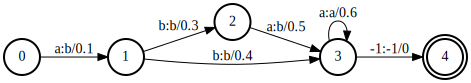

In [16]:
s = '''
0 1 1 2 0.1
1 2 2 2 0.3
1 3 2 2 0.4
2 3 1 2 0.5
3 3 1 1 0.6
3 4 -1 -1 0
4
'''
# k2.Fsa.from_str(s, acceptor=False)

sym_str = '''
 <eps> 0
 a 1
 b 2
 c 3
 d 4
 e 5
 f 6
'''
# a_fsa.symbols = k2.SymbolTable.from_str(sym_str)
# symbols, labels_sym, aux_labels_sym


# b_fst = k2.arc_sort(b_fst)
# b_fst.draw('b_fst.svg')

In [ ]:
s = '''
0 1 2 2 0.1
1 1 2 1 0.2
1 2 1 2 0.3
2 3 2 1 0.5
3 4 -1 -1 0.6
4
'''
# k2.Fsa.from_str(s)

sym_str = '''
 <eps> 0
 a 1
 b 2
 c 3
 d 4
 e 5
 f 6
'''
# a_fsa.symbols = k2.SymbolTable.from_str(sym_str)
# symbols, labels_sym, aux_labels_sym


# b_fst = k2.arc_sort(b_fst)
# b_fst.draw('b_fst.svg')

In [ ]:
# compose
bc =

In [ ]:
# determinization
a_fsa.draw('a_fsa.svg')

In [ ]:
a_deter = k2.determinize(a_fsa)
a_deter = k2.arc_sort(a_deter)
a_deter.labels_sym = k2.SymbolTable.from_str(sym_str)
a_deter.draw('deter.svg')

# WFST
⁻ U (utterance) WFSA: End-to-end 모델로부터 생성 (본 실습에서는 CTC 기반의 모델)  
⁻ C (CTC) WFST: CTC output을 subword로 collapsing할 수 있는 transducer  
⁻ L (Lexicon) WFST: subword를 word로 바꿔주는 transducer  
⁻ G (Grammar) WFST: 언어 모델을 사용하여 scoring하는 transducer  

In [37]:
!gdown --id 1_n-g04-8Kk_Lv4Kw3_6gW2ZO-9d_RAC4 --output logits.pt
!gdown --id 1GRvCoPI-Laq33yQIN5ErVbccN80yafwW --output lang/lm/lexicon.txt
!gdown --id 1pOoccbovNdm2Wxo-mXazpSWEi7FibcyV --output lang/lm/libri_3_gram.arpa.gz
!gdown --id 1s4P_PuwN6NVVVKu68I02oLKpZsnkPqYx --output lang/lm/tokens.txt
!gdown --id 1ok0ww50lIBTYELayrgZRaVt0EeV3Eg9U --output lang/lm/words.txt
!gdown --id 1KUboQqmJoymk1ptpI0cuotaxvpE33sOu --output lang/lm/word.raw
!gdown --id 1qomtuOyUM68c4MPfowggSf7fDVtRKDQw --output utils.py

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_n-g04-8Kk_Lv4Kw3_6gW2ZO-9d_RAC4
To: /content/logits.pt
100% 252M/252M [00:03<00:00, 76.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GRvCoPI-Laq33yQIN5ErVbccN80yafwW
To: /content/lang/lm/lexicon.txt
100% 24.5M/24.5M [00:00<00:00, 70.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.co

In [9]:
!gzip -d lang/lm/libri_3_gram.arpa.gz

gzip: lang/lm/libri_3_gram.arpa already exists; do you wish to overwrite (y or n)? ^C


In [10]:
words_values = k2.SymbolTable.from_file('lang/lm/words.txt')
tokens_values = k2.SymbolTable.from_file('lang/lm/tokens.txt')

## CTC transducer & Lexicon transducer

- CTC transducer의 경우 k2의 내장 함수를 이용해서 쉽게 구현할 수 있음

In [11]:
C = k2.ctc_topo(max_token=129, modified=False)

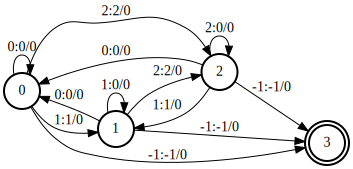

In [12]:
# draw ctc transducer
C_draw = k2.ctc_topo(max_token=2)
C_draw.draw('C_draw.svg')

- read_lexicon method를 통한 Lexicon Transduser 불러오기  
- Composition을 위한 disambig symbols 추가
- lexicon을 fst로 변경

In [17]:
from utils import read_lexicon

lexicon = read_lexicon("lang/lm/lexicon.txt")

In [18]:
from utils import add_disambig_symbols

lexicon_disambig, max_disambig = add_disambig_symbols(lexicon)

In [19]:
max_disambig

1

In [20]:
tokens_values.add('#0', 128)
tokens_values.add('#1', 129)

print(tokens_values.get('#0'), tokens_values.get('#1'))

128 129


In [21]:
from utils import lexicon_to_fst

L = lexicon_to_fst(
    lexicon_disambig,
    token2id=tokens_values._sym2id,
    word2id=words_values._sym2id,
    need_self_loops=True
)

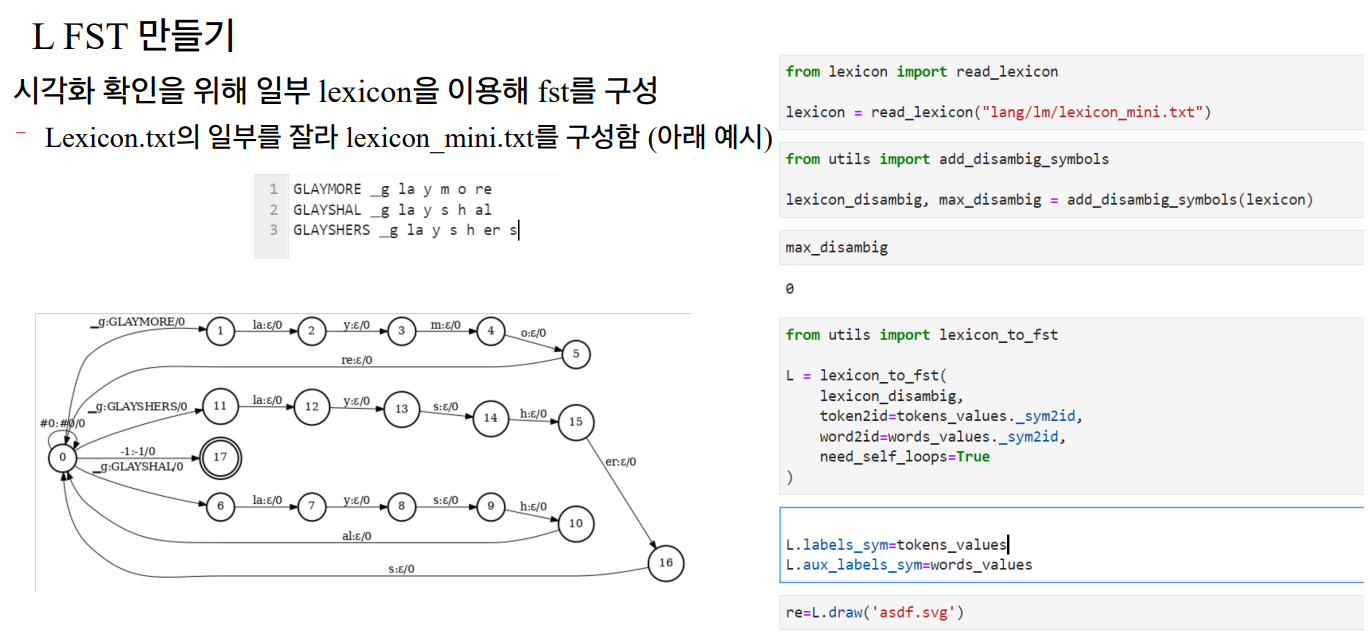

## Grammar transducer
- Arpa format을 openFST 스타일의 fst로 변환할 수 있는 kaldilm library 설치 및 실행
- OpenFST 스타일의 fst.txt를 불러와서 k2스타일로 저장

In [22]:
!pip install kaldilm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00


In [24]:
!python3 -m kaldilm --read-symbol-table="lang/lm/words.txt" --disambig-symbol='#0' --max-order=3 lang/lm/libri_3_gram.arpa > lang/G.fst.txt

/project/kaldilm/csrc/arpa_file_parser.cc:void kaldilm::ArpaFileParser::Read(std::istream&):79
[I] Reading \data\ section.
/project/kaldilm/csrc/arpa_file_parser.cc:void kaldilm::ArpaFileParser::Read(std::istream&):140
[I] Reading \1-grams: section.
/project/kaldilm/csrc/arpa_file_parser.cc:void kaldilm::ArpaFileParser::Read(std::istream&):213
[W] line 9 [-2.752519	<UNK>	-0.2779175] skipped: word '<UNK>' not in symbol table
/project/kaldilm/csrc/arpa_file_parser.cc:void kaldilm::ArpaFileParser::Read(std::istream&):213
[W] line 186182 [-6.437047	UNSELECTED	-0.04899115] skipped: word 'UNSELECTED' not in symbol table
/project/kaldilm/csrc/arpa_file_parser.cc:void kaldilm::ArpaFileParser::Read(std::istream&):213
[W] line 186183 [-6.091385	UNSELF	-0.611021] skipped: word 'UNSELF' not in symbol table
/project/kaldilm/csrc/arpa_file_parser.cc:void kaldilm::ArpaFileParser::Read(std::istream&):213
[W] line 186184 [-6.202638	UNSELFCONSCIOUS] skipped: word 'UNSELFCONSCIOUS' not in symbol table
/p

In [26]:
import torch

with open("lang/G.fst.txt") as f:
  G = k2.Fsa.from_openfst(f.read(), acceptor=False)
  torch.save(G.as_dict(), "lang/G.pt")

print(G.shape)

(2155145, None)


## Composition & Determinization

### Composition

In [27]:
L = k2.arc_sort(L)
G = k2.arc_sort(G)

LG = k2.compose(L, G)
#L_inv = L.invert()
#L_inv = k2.arc_sort(L_inv)
#L_inv.rename_tensor_attribute_('aux_labels', 'left_labels')
#LG = k2.intersect(L_inv, G, treat_epsilons_specially=True)
#LG.rename_tensor_attribute_('left_labels', 'labels')
LG = k2.connect(LG)

print(LG.shape)

(10110557, None)


### Determinization

In [28]:
LG = k2.determinize(LG)
LG = k2.connect(LG)
print(LG.shape)

(7508309, None)


### Epsilon removal

In [29]:
LG.labels[LG.labels >= tokens_values["#0"]] = 0
# See https://github.com/k2-fsa/k2/issues/874
# for why we need to set LG.properties to None
LG.__dict__["_properties"] = None

assert isinstance(LG.aux_labels, k2.RaggedTensor)
LG.aux_labels.values[LG.aux_labels.values >= words_values["#0"]] = 0

LG = k2.remove_epsilon(LG)
#logging.info(f"LG shape after k2.remove_epsilon: {LG.shape}")

LG = k2.connect(LG)
LG.aux_labels = LG.aux_labels.remove_values_eq(0)

In [33]:
print(LG.shape)

(4191914, None)


## CLG composition

In [30]:
torch.save(LG.as_dict(), "lang/LG.pt")

In [31]:
C = k2.arc_sort(C)
LG = k2.arc_sort(LG)

In [32]:
CLG = k2.compose(C, LG)

CLG = k2.connect(CLG)

print(CLG.shape)

(8383944, None)


In [34]:
torch.save(CLG.as_dict(), 'lang/CLG.pt')

In [35]:
import k2, torch
CLG = k2.Fsa.from_dict(torch.load('lang/CLG.pt', map_location="cpu"))

## Utterance transducer

In [38]:
import torch
nnet_outputs = torch.load('logits.pt')

In [39]:
print(len(nnet_outputs))
print(nnet_outputs[0].shape)

2620
torch.Size([487, 129])


In [40]:
def rearrange_blksym(nnet_outputs):
    nnet_t = nnet_outputs.T
    tmp = nnet_t[1:-1]
    tmp2 = nnet_t[-1:]
    logits = torch.cat([tmp2, tmp])
    logits = logits.T
    logits = torch.tensor([logits.numpy()])

    return logits


In [41]:
logits = rearrange_blksym(nnet_outputs[0])

<ipython-input-40-509705e966f4>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  logits = torch.tensor([logits.numpy()])


In [42]:
logits.shape

torch.Size([1, 487, 128])

In [43]:
supervision_segments = torch.tensor([[0, 0, logits.shape[1]]], dtype=torch.int32)

In [44]:
dense_fsa_vec = k2.DenseFsaVec(
    logits,
    supervision_segments)

In [45]:
lattice = k2.intersect_dense_pruned(CLG, dense_fsa_vec, 30.0, 15, 30, 1000000)

In [46]:
best_path = k2.shortest_path(lattice, use_double_scores=True)

In [47]:
from utils import get_texts

token_ids = get_texts(best_path)
hyp = [[words_values[i] for i in ids] for ids in token_ids]
print(" ".join(hyp[0]))

AT THE CONCLUSION OF THE BANQUET THAT SERVED AT FIVE O'CLOCK THE KING ENTERED HIS CABINET PHERE HIS TAILORS AERE AWAITING HIM FOR THE PURPOSE OF TRYING ON THE CELEBRATED COSTUME REPRESENTING SPRING THIS IS THE RESULT OF SO MUCH IMAGINATION AND HAD CAUSED SO MANY EFFORTS OF THOUGHT TO THE DESIGNERS AND ORNAMENT PORKERS OF THE COURT


In [ ]:
token_ids